In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Original dataset
raw = pd.read_csv("../OnlineNewsPopularity.csv").set_index('url')

# Results of my own scraping
update_data = pd.read_csv("Updates.csv").set_index('url')

# Updates Dataframe
Since this was data scrapped from the articles, its bound to be a bit messy

In [2]:
update = update_data.copy()

# Sperate the time stamp into weekday and date
update['weekday'] = update['date'].str.split(",", n = 1, expand = True)[0]
update['date'] = pd.to_datetime(update['date'].str.split(",", n = 1, expand = True)[1])

# Edit text of titles and keywords
def remove_text(column,text_list):
    update[column] = update[column].str.lower()
    for string in text_list:
        update[column] = update[column].str.replace(string,'')
        
remove = [r"\<.*?\>",'amp;','[',']']
remove_text('keywords',remove)
remove_text('title',remove)

update.head()

,channel,date,title,keywords,weekday
url,,,,,
http://mashable.com/2013/01/07/astronaut-notre-dame-bcs/,Entertainment,2013-01-07,this astronaut is rooting for notre dame tonight,"space, college football, entertainment, sports",Mon
http://mashable.com/2013/01/07/earth-size-planets-milky-way/,World,2013-01-07,there are 17 billion earth-size alien planets ...,"alien planets, earth, space, world",Mon
http://mashable.com/2013/01/07/apple-40-billion-app-downloads/,Business,2013-01-07,apple's app store passes 40 billion downloads,"apple, apps, apps and software, business, mobile",Mon
http://mashable.com/2013/01/07/downton-abbey-tumblrs/,Culture,2013-01-07,8 'downton abbey' tumblrs suitable for aristoc...,"downton abbey, gallery, memes, tumblr, televis...",Mon
http://mashable.com/2013/01/07/att-u-verse-apps/,Tech,2013-01-07,new u-verse apps simplify sharing photos and v...,"apps, apps and software, at&t, ces, tech",Mon


## Keywords
split the keywords columns into something useable

In [3]:
# Split the keywords into seperate entries
keywords_df = update.keywords.dropna().str.split(', ',expand=True).reset_index()
keywords_df = pd.melt(keywords_df,id_vars=['url'],value_name='keyword')
keywords_df = keywords_df.dropna().drop(columns='variable')

# Create a new data frame made up of keywords, shares, and url
keyword_shares = keywords_df.merge(raw.shares, how='left',on='url')
keyword_shares = keyword_shares[keyword_shares.url != ''].set_index('url')
keyword_shares.head()

,keyword,shares
url,,
http://mashable.com/2013/01/07/astronaut-notre-dame-bcs/,space,1200
http://mashable.com/2013/01/07/earth-size-planets-milky-way/,alien planets,1600
http://mashable.com/2013/01/07/apple-40-billion-app-downloads/,apple,1500
http://mashable.com/2013/01/07/downton-abbey-tumblrs/,downton abbey,761
http://mashable.com/2013/01/07/att-u-verse-apps/,apps,505


In [4]:
# Drop keywords only used once
keyword_counts = keyword_shares.keyword.value_counts()
keyword_counts = keyword_counts[keyword_counts>1].index

keyword_shares = keyword_shares.reset_index().set_index('keyword').loc[keyword_counts]
keyword_shares = keyword_shares.reset_index().set_index('url')

In [5]:
# Get the min, avg, and max of each keyword
kw_min_max = keyword_shares.groupby('keyword').max().rename(columns={'shares':'max'})
kw_min_max['avg'] = keyword_shares.groupby('keyword').mean().astype('int')
kw_min_max['min'] = keyword_shares.groupby('keyword').min()

In [6]:
# Select the feautres of the best, worst, and middle keywords

kw_dict = {'url':[],
          'kw_min':[],'kw_min_min':[],'kw_min_avg':[],'kw_min_max':[],
          'kw_avg':[],'kw_avg_min':[],'kw_avg_avg':[],'kw_avg_max':[],
          'kw_max':[],'kw_max_min':[],'kw_max_avg':[],'kw_max_max':[]}

for url in keyword_shares.index.unique():
    article = keyword_shares.loc[url]
    if type(article) == pd.core.series.Series:
        key = article.loc['keyword']
        min_share = kw_min_max.loc[key]['min']
        avg_share = kw_min_max.loc[key]['avg']
        max_share = kw_min_max.loc[key]['max']
        
        kw_dict['url'].append(url)
        
        for col in ['kw_min','kw_avg','kw_max']:
            kw_dict[col].append(key)
            
        for col in ['min','avg','max']:
            kw_dict['kw_'+col+'_min'].append(min_share)
            kw_dict['kw_'+col+'_avg'].append(avg_share)
            kw_dict['kw_'+col+'_max'].append(max_share)
        
    if type(article) == pd.core.frame.DataFrame:
        keys = article['keyword'].values
        article_kw = kw_min_max.loc[keys].sort_values('avg').reset_index()
  
        kw_min = article_kw.iloc[0]
        kw_max = article_kw.iloc[-1]
        kw_avg = article_kw.iloc[int(len(article)/2)]
          
        kw_dict['url'].append(url)
    
        kw_dict['kw_min'].append(kw_min['keyword'])
        kw_dict['kw_min_min'].append(kw_min['min'])
        kw_dict['kw_min_avg'].append(kw_min['avg'])
        kw_dict['kw_min_max'].append(kw_min['max'])
        
        kw_dict['kw_avg'].append(kw_avg['keyword'])
        kw_dict['kw_avg_min'].append(kw_avg['min'])
        kw_dict['kw_avg_avg'].append(kw_avg['avg'])
        kw_dict['kw_avg_max'].append(kw_avg['max'])
        
        kw_dict['kw_max'].append(kw_max['keyword'])
        kw_dict['kw_max_min'].append(kw_max['min'])
        kw_dict['kw_max_avg'].append(kw_max['avg'])
        kw_dict['kw_max_max'].append(kw_max['max'])

kw_min_max_all = pd.DataFrame(kw_dict).set_index('url')
kw_min_max_all

,kw_min,kw_min_min,kw_min_avg,kw_min_max,kw_avg,kw_avg_min,kw_avg_avg,kw_avg_max,kw_max,kw_max_min,kw_max_avg,kw_max_max
url,,,,,,,,,,,,
http://mashable.com/2013/02/14/iceland-ban-porn/,world,22,3223,310800,world,22,3223,310800,world,22,3223,310800
http://mashable.com/2013/02/28/pope-benedict-last-tweet/,pope francis,404,2963,23600,world,22,3223,310800,world,22,3223,310800
http://mashable.com/2013/03/13/pope-francis-facebook/,pope francis,404,2963,23600,world,22,3223,310800,world,22,3223,310800
http://mashable.com/2013/03/27/biggest-cyberattack/,world,22,3223,310800,world,22,3223,310800,world,22,3223,310800
http://mashable.com/2013/03/28/ddos-attacks-not-the-only-way-to-disrupt-internet/,world,22,3223,310800,world,22,3223,310800,world,22,3223,310800
...,...,...,...,...,...,...,...,...,...,...,...,...
http://mashable.com/2014/11/24/pablo-sandoval-boston/,giants,844,2428,4700,san francisco giants,1300,4040,7800,world series,912,4214,19100
http://mashable.com/2014/03/17/global-translation/,translation,459,4262,11800,translation,459,4262,11800,translation,459,4262,11800
http://mashable.com/2013/04/24/best-idea-contest/,emerging tech hubs,2500,3566,7100,emerging tech hubs,2500,3566,7100,emerging tech hubs,2500,3566,7100


# Join Dataframes

In [7]:
update = update.merge(kw_min_max_all,how='right',right_index=True,left_index=True).drop(columns='keywords')

temp_data = raw.drop(columns=['kw_min_min','kw_min_avg','kw_min_max',
                          'kw_avg_min','kw_avg_avg','kw_avg_max',
                          'kw_max_min','kw_max_avg','kw_max_max'])

data = temp_data.reset_index().join(update, on='url',how='inner').set_index('url').dropna()

# Days of the Week
First of, since we have a new days of the week column, I'm going to drop the origionals

In [8]:
data = data.drop(columns=['weekday_is_monday','weekday_is_tuesday','weekday_is_wednesday',
                          'weekday_is_thursday','weekday_is_friday','weekday_is_saturday',
                          'weekday_is_sunday','is_weekend'])

In [9]:
def break_down(column,sort='total articles',show=True):
    counts = data[[column,'shares']].groupby(by=column).count().rename(columns={'shares':'total articles'})
    sums = data[[column,'shares']].groupby(by=column).sum().rename(columns={'shares':'sum shares'})
    group = counts.join(sums,on=column)
    
    # add the shares per article ratio
    group["shares per article ratio"] = group["sum shares"]/group["total articles"]

    # add percentages to make it easier to see
    group['percent of all shares'] = group['sum shares']/group['sum shares'].sum()*100
    group['percent of articles'] = group['total articles']/group['total articles'].sum()*100

    # sort
    group = group.sort_values('total articles',ascending=False)
    
    if show==True:
        group
    
    return group

break_down('weekday')

,total articles,sum shares,shares per article ratio,percent of all shares,percent of articles
weekday,,,,,
Wed,7501,25017056,3335.162778,18.685558,19.005270
Thu,7298,22993786,3150.696903,17.174352,18.490929
Tue,7187,24285807,3379.129957,18.139379,18.209689
Mon,6324,21947668,3470.535737,16.392993,16.023107
Fri,5998,19789487,3299.347616,14.781020,15.197122
Sat,2726,10806802,3964.344094,8.071738,6.906861
Sun,2434,9043838,3715.627773,6.754958,6.167021


Seems like less articles are published on Saturday and Sunday so I combined both these entries as `weekend`

In [10]:
data['weekday'] = data['weekday'].replace(['Sat','Sun'],'Weekend')
break_down('weekday')         

,total articles,sum shares,shares per article ratio,percent of all shares,percent of articles
weekday,,,,,
Wed,7501,25017056,3335.162778,18.685558,19.005270
Thu,7298,22993786,3150.696903,17.174352,18.490929
Tue,7187,24285807,3379.129957,18.139379,18.209689
Mon,6324,21947668,3470.535737,16.392993,16.023107
Fri,5998,19789487,3299.347616,14.781020,15.197122
Weekend,5160,19850640,3847.023256,14.826696,13.073883


# Data Channels
Do the same with data channel

In [11]:
data = data.drop(columns=['data_channel_is_lifestyle',' data_channel_is_entertainment','data_channel_is_bus',
                          'data_channel_is_socmed','data_channel_is_tech','data_channel_is_world'])

In [12]:
break_down('channel')

,total articles,sum shares,shares per article ratio,percent of all shares,percent of articles
channel,,,,,
Entertainment,10775,35489784,3293.715452,26.507773,27.300598
World,7616,24084453,3162.349396,17.988985,19.296645
Tech,7260,25208532,3472.249587,18.828574,18.394649
Business,6180,21250001,3438.511489,15.871897,15.658255
Culture,5250,19215172,3660.032762,14.352057,13.301915
Unlabeled,1182,3601668,3047.096447,2.690132,2.994831
U.S.,883,3673081,4159.774632,2.743471,2.237255
Social Good,322,1361753,4229.046584,1.017111,0.815851


The most articles are from the `Entertainment` category, followed by `World` and `Tech`. Understandably the highest sum shares come from the same categories.

Since `Social Good`, `US`, and the unlabeled data channels are so small, I just grouped them up into one category labeled `Other`

In [13]:
data['channel'] = data['channel'].replace(['Social Good','U.S.','Unlabeled'],'Other')
break_down('channel') 

,total articles,sum shares,shares per article ratio,percent of all shares,percent of articles
channel,,,,,
Entertainment,10775,35489784,3293.715452,26.507773,27.300598
World,7616,24084453,3162.349396,17.988985,19.296645
Tech,7260,25208532,3472.249587,18.828574,18.394649
Business,6180,21250001,3438.511489,15.871897,15.658255
Culture,5250,19215172,3660.032762,14.352057,13.301915
Other,2387,8636502,3618.140762,6.450714,6.047938


# Distribution of Shares
Now that the weekdays and channels have been updated, lets look at the shares as a whole

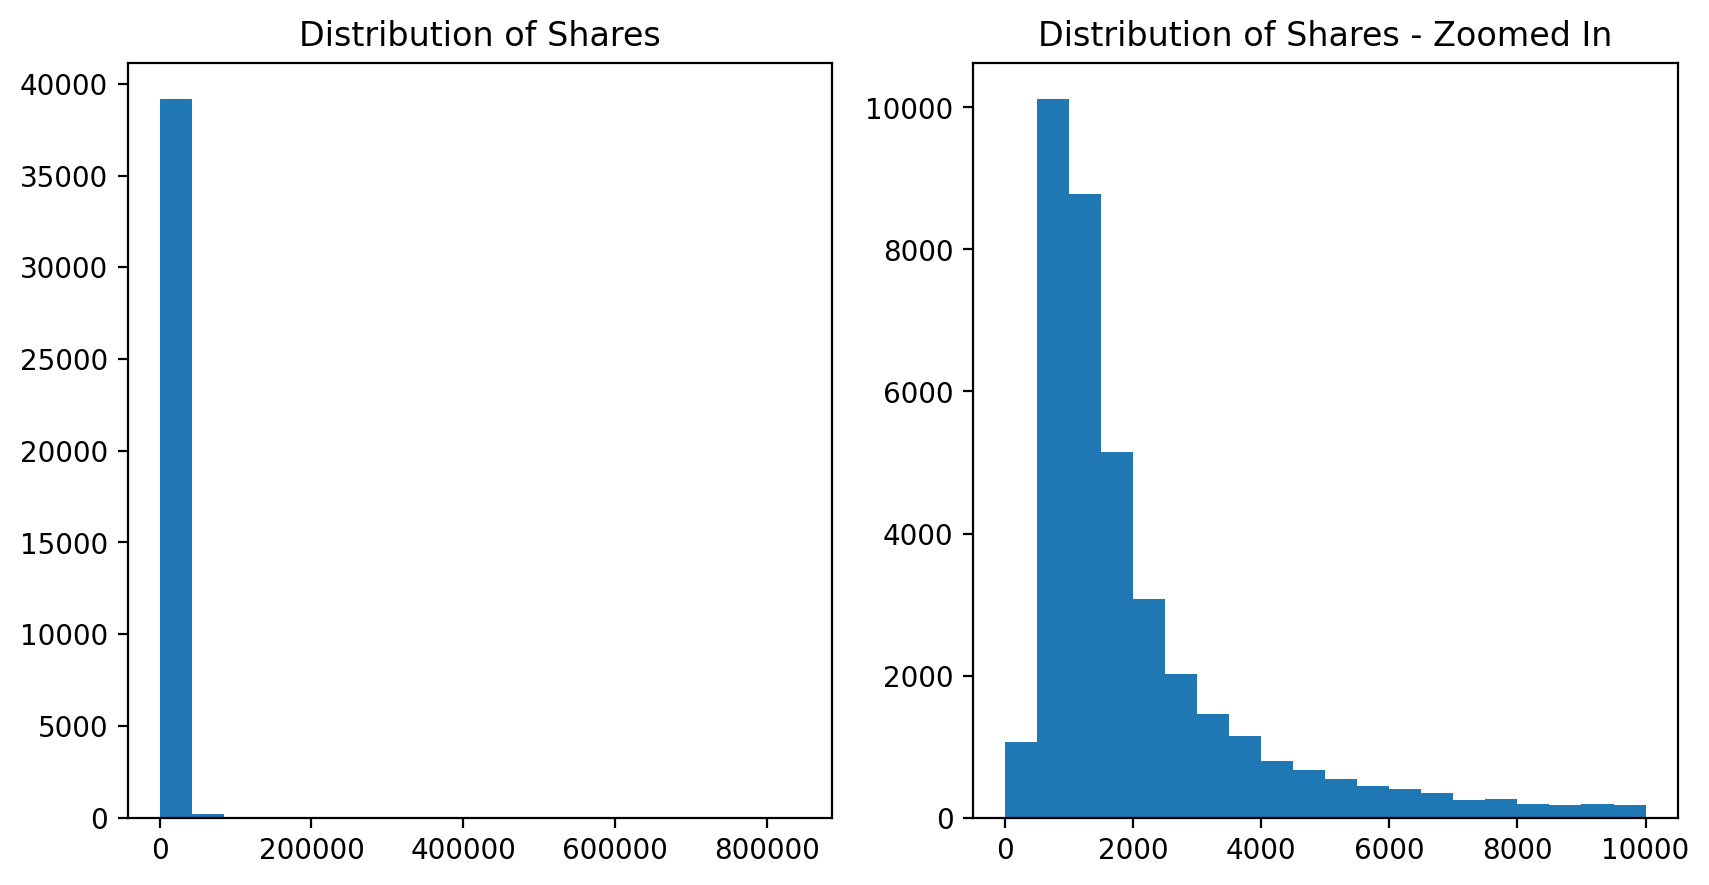

In [14]:
plt.figure(figsize=(10,5),dpi=200)

plt.subplot(121)
plt.hist(data['shares'],bins=20);
plt.title('Distribution of Shares')

plt.subplot(122)
plt.hist(data['shares'],bins=20,range=(0,10000))
plt.title('Distribution of Shares - Zoomed In');

Seems like there's alot of outlires. Viral articles get a whole lot more shares than the typical article

# Save Data

Saved the data as `OnlineNewsPopularity_Cleaned.csv`.

In [15]:
data.head()

,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,...,kw_min_avg,kw_min_max,kw_avg,kw_avg_min,kw_avg_avg,kw_avg_max,kw_max,kw_max_min,kw_max_avg,kw_max_max
url,,,,,,,,,,,,,,,,,,,,,
http://mashable.com/2013/01/07/amazon-instant-video-browser/,731.0,12.0,219.0,0.663594,1.0,0.815385,4.0,2.0,1.0,0.0,...,2722,83300,entertainment,5,3267,652900,video,5,3637,617900
http://mashable.com/2013/01/07/ap-samsung-sponsored-tweets/,731.0,9.0,255.0,0.604743,1.0,0.791946,3.0,1.0,1.0,0.0,...,2943,74100,twitter,52,3349,145500,business,44,3431,690400
http://mashable.com/2013/01/07/apple-40-billion-app-downloads/,731.0,9.0,211.0,0.575130,1.0,0.663866,3.0,1.0,1.0,0.0,...,3249,298400,business,44,3431,690400,apps,47,3526,143100
http://mashable.com/2013/01/07/astronaut-notre-dame-bcs/,731.0,9.0,531.0,0.503788,1.0,0.665635,9.0,0.0,1.0,0.0,...,1342,3100,sports,43,3140,200100,entertainment,5,3267,652900
http://mashable.com/2013/01/07/att-u-verse-apps/,731.0,13.0,1072.0,0.415646,1.0,0.540890,19.0,19.0,20.0,0.0,...,2686,53100,apps and software,47,3447,211600,apps,47,3526,143100


In [16]:
data.to_csv('../OnlineNewsPopularity_Clean.csv')